# Uncertainty appraisal provides useful information for the management of manual grape harvest

## Import all the relevant libraries

In [1]:
import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy import special
import seaborn as sns
import sobol_seq

## Import and pre-processing of the data sets

### Import the datasets

In [2]:
wineyard = pd.concat([pd.read_csv('max min.csv',header=0,index_col=0,usecols=[0,3,4]),
                      pd.read_csv('dati dist normale.csv',header=0,index_col=0,usecols=[0,3,4]),
                     pd.read_csv('rese max min.csv',header=0,index_col=0,usecols=[0,1,2]),
                     pd.read_csv('rese media sd.csv',header=0,index_col=0),
                     pd.read_csv('prod max min.csv',header=0,index_col=0),
                     pd.read_csv('prod mean sd.csv',header=0,index_col=0)],axis=1)
wineyard.columns =['Date_max','Date_min','Date_avg','Date_std',
                   'Yield_max','Yield_min','Yield_avg','Yield_std',
                   'Productivity_max','Productivity_min','Productivity_avg','Productivity_std']
# wineyard['Productivity_max']=wineyard.Yield_max/pd.read_csv('max min.csv',index_col=0,header=0,usecols=[0,1,2]).iloc[:,1]
# wineyard['Productivity_min']=wineyard.Yield_min/pd.read_csv('max min.csv',index_col=0,header=0,usecols=[0,1,2]).iloc[:,0]
# wineyard['Productivity_avg']=wineyard[['Yield_max','Yield_min']].mean(axis=1)
# wineyard['Productivity_std']=np.sqrt(wineyard.Yield_avg)
rain = pd.read_csv('pioggia2.csv',header=0,index_col=0).loc[229:306] #Cap it to the days one will be actually using
rain.columns = ['p_5_mm','p_15_mm']
# bottle_prices = pd.read_excel('vitigni vini prezzi.xlsx',header=0,usecols=[1,2]).sort_values(by='Prezzo',ascending=False)

Set the range for the min,max hour-man requirement

In [3]:
hourman = pd.read_csv('max min.csv',header=0,index_col=0,usecols=[0,1,2])
hourman_ranges = [round(hourman['OU min'].max()/10),round(hourman['OU max'].max()/8)]
hourman_ranges

[8, 17]

These lines are used to define the truncation thresholds for the yields and productivity distributions, which is assumed as the field showing the largest ration (min, max - avg)/std -> 1.2 std

In [4]:
wineyard['Yield_diff_min']=(np.abs(wineyard.Yield_min-wineyard.Yield_avg)/wineyard.Yield_std).round(2)
wineyard['Yield_diff_max']=(np.abs(wineyard.Yield_max-wineyard.Yield_avg)/wineyard.Yield_std).round(2)
wineyard['Productivity_diff_min']=(np.abs(wineyard.Productivity_min-wineyard.Productivity_avg)/wineyard.Productivity_std).round(2)
wineyard['Productivity_diff_max']=(np.abs(wineyard.Productivity_max-wineyard.Productivity_avg)/wineyard.Productivity_std).round(2)

In [5]:
wineyard['Date_lower']= 229 #August 16
wineyard['Date_upper']= 305 #October 31, leap year

wineyard['Yield_lower']= wineyard.Yield_avg-wineyard.Yield_std*1.2 #Driven by the max possible variability across wineyards
wineyard['Yield_upper']= wineyard.Yield_avg+wineyard.Yield_std*1.2 #Driven by the max possible variability across wineyards
wineyard['Productivity_lower']= wineyard.Productivity_avg-wineyard.Productivity_std*1.2 #Driven by the max possible variability across wineyards
wineyard['Productivity_upper']= wineyard.Productivity_avg+wineyard.Productivity_std*1.2 #Driven by the max possible variability across wineyards

wineyard.index = [r+1 for r in range(len(wineyard))]
# wineyard['vitigni']=pd.read_csv('vigneti vitigni.csv',header=0,index_col=0,usecols=[0,1])
# wineyard=wineyard.set_index([wineyard.index,'vitigni'])

The base matrix for the distribution is then imported

In [6]:
# trigger manpower distribution, trigger date distribution, 
# manpower normal distribution, manpower uniform distribution, date normal distribution, date manpower distribution
# trigger rain, rain 5 mm, rain 15 mm
# trigger extra hours, work on Sundays, weekly call
sampleTot = sobol_seq.i4_sobol_generate(40,-1+2**14).T

And the individual distributions produced as per the features agreed

In [7]:
sample_rain_5 = []
sample_rain_15 = []
sample_rain_5B = []
sample_rain_15B = []
for i,row in rain.iterrows():
    sample_rain_5.append(rain.loc[i,'p_5_mm']<sampleTot[28])
    sample_rain_15.append(rain.loc[i,'p_15_mm']<sampleTot[28])
    sample_rain_5B.append(rain.loc[i,'p_5_mm']<sampleTot[29])
    sample_rain_15B.append(rain.loc[i,'p_15_mm']<sampleTot[29])
sample_rain = pd.DataFrame(([np.concatenate(sample_rain_5),np.concatenate(sample_rain_15)]),index=['rain_5mm','rain_15mm']).T
sample_rainB = pd.DataFrame(([np.concatenate(sample_rain_5B),np.concatenate(sample_rain_15B)]),index=['rain_5mm','rain_15mm']).T
sample_rain.index = [ri for ri in rain.index for r in range(len(sampleTot.T))]
sample_rain['random_index']=[r for q in range(len(rain)) for r in range(len(sampleTot.T))]
sample_rain = sample_rain.set_index([sample_rain.index,'random_index'])
sample_rainB.index=sample_rain.index
# sample_rain

In [8]:
sample = pd.concat([pd.concat([pd.Series(wineyard.Yield_avg.loc[i]+np.sqrt(2)*wineyard.Yield_std.loc[i]*special.erfinv(
    sampleTot[0]*special.erf((wineyard.Yield_upper.loc[i]-wineyard.Yield_avg.loc[i])/(np.sqrt(2)*wineyard.Yield_std.loc[i]))+
    (1-sampleTot[0])*special.erf((wineyard.Yield_lower.loc[i]-wineyard.Yield_avg).loc[i]/(np.sqrt(2)*wineyard.Yield_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Yield_min.loc[i]+(wineyard.Yield_max.loc[i]-wineyard.Yield_min.loc[i])*sampleTot[1])
                    for i, row in wineyard.iterrows()]),
                    pd.concat([pd.Series(wineyard.Productivity_avg.loc[i]+np.sqrt(2)*wineyard.Productivity_std.loc[i]*special.erfinv(
    sampleTot[2]*special.erf((wineyard.Productivity_upper.loc[i]-wineyard.Productivity_avg.loc[i])/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))+
    (1-sampleTot[2])*special.erf((wineyard.Productivity_lower.loc[i]-wineyard.Productivity_avg).loc[i]/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Productivity_min.loc[i]+(wineyard.Productivity_max.loc[i]-wineyard.Productivity_min.loc[i])*sampleTot[3])
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_avg.loc[i]+np.sqrt(2)*wineyard.Date_std.loc[i]*special.erfinv(
    sampleTot[4]*special.erf((wineyard.Date_upper.loc[i]-wineyard.Date_avg.loc[i])/(np.sqrt(2)*wineyard.Date_std.loc[i]))+
    (1-sampleTot[4])*special.erf((wineyard.Date_lower.loc[i]-wineyard.Date_avg).loc[i]/(np.sqrt(2)*wineyard.Date_std.loc[i])))).astype(int)
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_min.loc[i]+(wineyard.Date_max.loc[i]-wineyard.Date_min.loc[i])*sampleTot[5]).astype(int)
                    for i, row in wineyard.iterrows()])],axis=1)
sample.columns = ['Yield_gaussian','Yield_uniform',
                  'Productivity_gaussian','Productivity_uniform',
                  'Date_gaussian','Date_uniform']
sample.index = [wi for wi in wineyard.index for r in range(len(sampleTot.T))]
sample['Yield_trigger']=sample.columns[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))]
sample['Productivity_trigger']=sample.columns[np.tile((sampleTot[7]+2).round(0).astype(int), len(wineyard))]
sample['Date_trigger']=sample.columns[np.tile((sampleTot[8]+4).round(0).astype(int), len(wineyard))]
sample['Workers']=np.tile((sampleTot[9]*(max(hourman_ranges)-min(hourman_ranges))+\
                                                  min(hourman_ranges)).round(0).astype(int), len(wineyard))
sample['Rain_trigger']=sample_rain.columns[np.tile(sampleTot[10].round(0).astype(int), len(wineyard))]
sample['Hours_extra']=np.tile(8+(sampleTot[11]).round(0).astype(int)*2, len(wineyard))
sample['Sundays_work']=np.tile(sampleTot[12]<0.1, len(wineyard))
sample['Sundays']=np.tile(pd.Series([[(q*7).astype(int)+229+7*r for r in range(11)] for q in sampleTot[13]]),len(wineyard))
# sample['Weekly_call']=np.tile(sampleTot[12]<0.5, len(wineyard))
sample['random_index']=[r for q in range(len(wineyard)) for r in range(len(sampleTot.T))]
# sample = sample.set_index([pd.MultiIndex.from_tuples(sample.index.get_level_values(0)),'random_index'])
sample = sample.set_index([sample.index,'random_index'])
# sample

sampleB = pd.concat([pd.concat([pd.Series(wineyard.Yield_avg.loc[i]+np.sqrt(2)*wineyard.Yield_std.loc[i]*special.erfinv(
    sampleTot[14]*special.erf((wineyard.Yield_upper.loc[i]-wineyard.Yield_avg.loc[i])/(np.sqrt(2)*wineyard.Yield_std.loc[i]))+
    (1-sampleTot[14])*special.erf((wineyard.Yield_lower.loc[i]-wineyard.Yield_avg).loc[i]/(np.sqrt(2)*wineyard.Yield_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Yield_min.loc[i]+(wineyard.Yield_max.loc[i]-wineyard.Yield_min.loc[i])*sampleTot[15])
                    for i, row in wineyard.iterrows()]),
                    pd.concat([pd.Series(wineyard.Productivity_avg.loc[i]+np.sqrt(2)*wineyard.Productivity_std.loc[i]*special.erfinv(
    sampleTot[16]*special.erf((wineyard.Productivity_upper.loc[i]-wineyard.Productivity_avg.loc[i])/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))+
    (1-sampleTot[16])*special.erf((wineyard.Productivity_lower.loc[i]-wineyard.Productivity_avg).loc[i]/(np.sqrt(2)*wineyard.Productivity_std.loc[i]))))
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Productivity_min.loc[i]+(wineyard.Productivity_max.loc[i]-wineyard.Productivity_min.loc[i])*sampleTot[17])
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_avg.loc[i]+np.sqrt(2)*wineyard.Date_std.loc[i]*special.erfinv(
    sampleTot[18]*special.erf((wineyard.Date_upper.loc[i]-wineyard.Date_avg.loc[i])/(np.sqrt(2)*wineyard.Date_std.loc[i]))+
    (1-sampleTot[18])*special.erf((wineyard.Date_lower.loc[i]-wineyard.Date_avg).loc[i]/(np.sqrt(2)*wineyard.Date_std.loc[i])))).astype(int)
                    for i, row in wineyard.iterrows()]),
        pd.concat([pd.Series(wineyard.Date_min.loc[i]+(wineyard.Date_max.loc[i]-wineyard.Date_min.loc[i])*sampleTot[19]).astype(int)
                    for i, row in wineyard.iterrows()])],axis=1)
sampleB.columns = ['Yield_gaussian','Yield_uniform',
                  'Productivity_gaussian','Productivity_uniform',
                  'Date_gaussian','Date_uniform']
sampleB.index = [wi for wi in wineyard.index for r in range(len(sampleTot.T))]
sampleB['Yield_trigger']=sampleB.columns[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))]
sampleB['Productivity_trigger']=sampleB.columns[np.tile((sampleTot[21]+2).round(0).astype(int), len(wineyard))]
sampleB['Date_trigger']=sampleB.columns[np.tile((sampleTot[22]+4).round(0).astype(int), len(wineyard))]

sampleB['Workers']=np.tile((sampleTot[23]*(max(hourman_ranges)-min(hourman_ranges))+\
                                                  min(hourman_ranges)).round(0).astype(int), len(wineyard))
sampleB['Rain_trigger']=sample_rainB.columns[np.tile(sampleTot[24].round(0).astype(int), len(wineyard))]
sampleB['Hours_extra']=np.tile(8+(sampleTot[25]).round(0).astype(int)*2, len(wineyard))
sampleB['Sundays_work']=np.tile(sampleTot[26]<0.1, len(wineyard))
sampleB['Sundays']=np.tile(pd.Series([[(q*7).astype(int)+229+7*r for r in range(11)] for q in sampleTot[27]]),len(wineyard))
# sample['Weekly_call']=np.tile(sampleTot[12]<0.5, len(wineyard))
sampleB['random_index']=[r for q in range(len(wineyard)) for r in range(len(sampleTot.T))]
# sample = sample.set_index([pd.MultiIndex.from_tuples(sample.index.get_level_values(0)),'random_index'])
sampleB = sampleB.set_index([sampleB.index,'random_index'])

In [9]:
sample.Yield_gaussian.groupby(level=1).sum().describe()

count    16383.000000
mean        71.081667
std          3.529278
min         64.340991
25%         68.256848
50%         71.081667
75%         73.906485
max         77.822343
Name: Yield_gaussian, dtype: float64

In [10]:
sample.Yield_uniform.groupby(level=1).sum().describe()

count    16383.00000
mean        71.42000
std          2.93285
min         66.34062
25%         68.88031
50%         71.42000
75%         73.95969
max         76.49938
Name: Yield_uniform, dtype: float64

In [11]:
sample.Yield_gaussian.groupby(level=1).sum().var()

12.45580151824133

Produce the plot of the maturation dates distribution across wine yards

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDepreca

<Figure size 16000x10000 with 0 Axes>

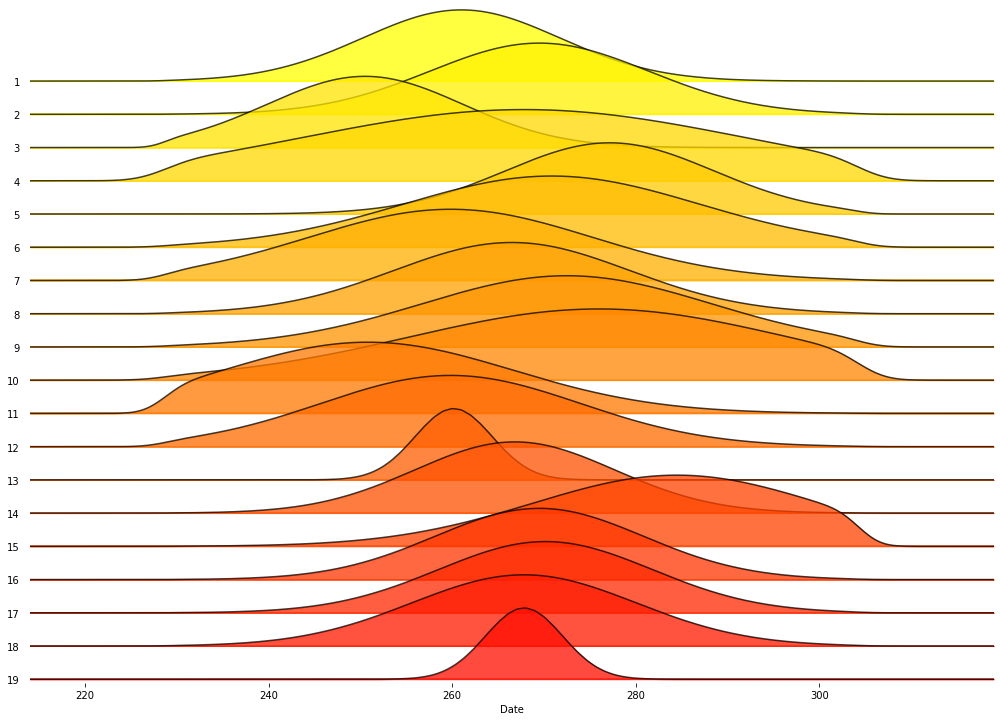

In [12]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 1000)
fig, axes = joypy.joyplot(sample, 
                          column=['Date_gaussian'],
                          by=sample.index.get_level_values(0), 
                          ylim='own',
                          alpha = .75,
                          colormap=cm.autumn_r,
                          figsize=(14,10))
plt.xlabel('Date')
plt.ylabel('Wineyard')
plt.show()

Produce the scrambled matrices for the sensitivity analysis

In [ ]:
variables = ['Yield_gaussian','Yield_uniform','Productivity_gaussian','Productivity_uniform',
             'Date_gaussian','Date_uniform','Yield','Productivity','Date',
            'Workers','Rain_trigger','Hours_extra','Sundays_work','Sundays','Rain']

yield_list, productivity_list, date_list = [],[],[]
for es,s in enumerate(sampleB.iloc[:,:2].values):
    yield_list.append(s[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))[es]])
    productivity_list.append(sampleB.iloc[es,2:4][np.tile(sampleTot[21].round(0).astype(int), len(wineyard))[es]])
    date_list.append(sampleB.iloc[es,4:6][np.tile(sampleTot[22].round(0).astype(int), len(wineyard))[es]])
    
sampleB['Yield']= yield_list
sampleB['Productivity']= productivity_list
sampleB['Date']= date_list

sampleB['Hourman']=(sampleB.Yield/sampleB.Productivity).round(0).astype(int)

yield_list, productivity_list, date_list = [],[],[]
for es,s in enumerate(sample.iloc[:,:2].values):
    yield_list.append(s[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))[es]])
    productivity_list.append(sample.iloc[es,2:4][np.tile(sampleTot[7].round(0).astype(int), len(wineyard))[es]])
    date_list.append(sample.iloc[es,4:6][np.tile(sampleTot[8].round(0).astype(int), len(wineyard))[es]])
    
sample['Yield']= yield_list
sample['Productivity']= productivity_list
sample['Date']= date_list

sample['Hourman']=(sample.Yield/sample.Productivity).round(0).astype(int)

sM_A=[sample]

sample_requirement=pd.DataFrame(sample.groupby(['random_index','Date'])['Hourman'].sum())

days_worked_dict = {}
for es,s in sample.groupby(level=1):
    days_no_rain = rain.index[sample_rain.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
    days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
    if s.loc[1,'Sundays_work'].values[0] == False:
        days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc[1,'Sundays'].values[0])])
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
    else:
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
manpower_available.columns=['Hourman']

difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)

# difference.loc[difference.Hourman<0,'Hourman']=0

sample_requirement = sample_requirement.reset_index()
sample_requirement.index = sample_requirement.random_index

output = pd.concat([(np.abs(sample_requirement.Hourman-\
sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                    sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                   difference.groupby('random_index').sum()],axis=1)
output.columns = ['Hourman_discrepancy','Harvest_date_discrepancy','Hourman_deficit']

output_list = [output]

for iv, v in enumerate(variables):
    sM_A.append(sample.copy())
    if v != 'Rain':
        sM_A[-1][v]=sampleB[v]
    
    yield_list, productivity_list, date_list = [],[],[]
    for es,s in enumerate(sM_A[-1].iloc[:,:2].values):
        if iv == 6:
            yield_list.append(s[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))[es]])
        else:
            yield_list.append(s[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))[es]])
        if iv == 7:
            productivity_list.append(sM_A[-1].iloc[es,2:4][np.tile(sampleTot[21].round(0).astype(int), len(wineyard))[es]])
        else:
            productivity_list.append(sM_A[-1].iloc[es,2:4][np.tile(sampleTot[7].round(0).astype(int), len(wineyard))[es]])
        if iv == 8:
            date_list.append(sM_A[-1].iloc[es,4:6][np.tile(sampleTot[22].round(0).astype(int), len(wineyard))[es]])
        else:
            date_list.append(sM_A[-1].iloc[es,4:6][np.tile(sampleTot[8].round(0).astype(int), len(wineyard))[es]])

    sM_A[-1]['Yield']= yield_list
    sM_A[-1]['Productivity']= productivity_list
    sM_A[-1]['Date']= date_list
       
    sM_A[-1]['Hourman']=(sM_A[-1].Yield/sM_A[-1].Productivity).round(0).astype(int)
    
    sample_requirement=pd.DataFrame(sM_A[-1].groupby(['random_index','Date'])['Hourman'].sum())

    #set_days_available_when_not_raining and exclude Sundays if not in the trigger
    days_worked_dict = {}
    for es,s in sM_A[-1].groupby(level=1):
        if iv == 14:
            days_no_rain = rain.index[sample_rainB.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
        else:
            days_no_rain = rain.index[sample_rain.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
        if s.loc[1,'Sundays_work'].values[0] == False:
            days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc[1,'Sundays'].values[0])])
            days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
        else:
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

    manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
    manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
    manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

    manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
    manpower_available.columns=['Hourman']

    difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)
    
#     difference.loc[difference.Hourman<0,'Hourman']=0


    sample_requirement = sample_requirement.reset_index()
    sample_requirement.index = sample_requirement.random_index

    output = pd.concat([(np.abs(sample_requirement.Hourman-\
    sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                        sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                       difference.groupby('random_index').sum()],axis=1)
    output.columns = ['Hourman_discrepancy','Maturation_date_discrepancy','Hourman_deficit']
    output_list.append(output)
    
sM_A.append(sampleB)

sample_requirement=pd.DataFrame(sampleB.groupby(['random_index','Date'])['Hourman'].sum())

days_worked_dict = {}
for es,s in sampleB.groupby(level=1):
    days_no_rain = rain.index[sample_rainB.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
    days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
    if s.loc[1,'Sundays_work'].values[0] == False:
        days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc[1,'Sundays'].values[0])])
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
    else:
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
manpower_available.columns=['Hourman']

difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)

# difference.loc[difference.Hourman<0,'Hourman']=0

sample_requirement = sample_requirement.reset_index()
sample_requirement.index = sample_requirement.random_index

output = pd.concat([(np.abs(sample_requirement.Hourman-\
sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                    sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                   difference.groupby('random_index').sum()],axis=1)
output.columns = ['Hourman_discrepancy','Harvest_date_discrepancy','Hourman_deficit']
output_list.append(output)

Calculate the output variables for the B matrix for the sensitivity analysis

In [ ]:
output_listB = output_list.copy()
output_listB[0] = output_list[-1]
sM_B = []

for iv, v in enumerate(variables):
    sM_B.append(sampleB.copy())
    if v != 'Rain':
        sM_B[-1][v]=sample[v]
    
    yield_list, productivity_list, date_list = [],[],[]
    for es,s in enumerate(sM_B[-1].iloc[:,:2].values):
        if iv == 6:
            yield_list.append(s[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))[es]])
        else:
            yield_list.append(s[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))[es]])
        if iv == 7:
            productivity_list.append(sM_B[-1].iloc[es,2:4][np.tile(sampleTot[7].round(0).astype(int), len(wineyard))[es]])
        else:
            productivity_list.append(sM_B[-1].iloc[es,2:4][np.tile(sampleTot[21].round(0).astype(int), len(wineyard))[es]])
        if iv == 8:
            date_list.append(sM_B[-1].iloc[es,4:6][np.tile(sampleTot[8].round(0).astype(int), len(wineyard))[es]])
        else:
            date_list.append(sM_B[-1].iloc[es,4:6][np.tile(sampleTot[22].round(0).astype(int), len(wineyard))[es]])

    sM_B[-1]['Yield']= yield_list
    sM_B[-1]['Productivity']= productivity_list
    sM_B[-1]['Date']= date_list
       
    sM_B[-1]['Hourman']=(sM_B[-1].Yield/sM_B[-1].Productivity).round(0).astype(int)
    
    sample_requirement=pd.DataFrame(sM_B[-1].groupby(['random_index','Date'])['Hourman'].sum())

    #set_days_available_when_not_raining and exclude Sundays if not in the trigger
    days_worked_dict = {}
    for es,s in sM_B[-1].groupby(level=1):
        if iv == 14:
            days_no_rain = rain.index[sample_rain.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
        else:
            days_no_rain = rain.index[sample_rainB.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
        if s.loc[1,'Sundays_work'].values[0] == False:
            days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc[1,'Sundays'].values[0])])
            days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
        else:
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

    manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
    manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
    manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

    manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
    manpower_available.columns=['Hourman']

    difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)
    
#     difference.loc[difference.Hourman<0,'Hourman']=0


    sample_requirement = sample_requirement.reset_index()
    sample_requirement.index = sample_requirement.random_index

    output = pd.concat([(np.abs(sample_requirement.Hourman-\
    sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                        sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                       difference.groupby('random_index').sum()],axis=1)
    output.columns = ['Hourman_discrepancy','Harvest_date_discrepancy','Hourman_deficit']
    output_listB.append(output)

output_listB[-1] = output_list[0]

Slice the dataframe by fixing the number of workers

In [ ]:
workers_index = [sM_A[0][sM_A[0].Workers==s].index.get_level_values(1).drop_duplicates()
                 for s in np.sort(sM_A[0].Workers.unique())]

extrahours_index = [sM_A[0][sM_A[0].Hours_extra==s].index.get_level_values(1).drop_duplicates()
                 for s in np.sort(sM_A[0].Hours_extra.unique())]

Hourman_deficit_worker = [output_list[0].loc[w,'Hourman_deficit'] for w in workers_index]
Hourman_deficit_extrahours = [output_list[0].loc[h,'Hourman_deficit'] for h in extrahours_index]

Hourman_deficit_worker_df = pd.concat(Hourman_deficit_worker,axis=1)
Hourman_deficit_extrahours_df = pd.concat(Hourman_deficit_extrahours,axis=1)
Hourman_deficit_worker_df.columns = np.sort(sM_A[0].Workers.unique())
Hourman_deficit_extrahours_df.columns = np.sort(sM_A[0].Hours_extra.unique())

Assess the sensitivity indices

In [ ]:
Var = pd.concat([output_list[0],output_list[-1]],axis=0).var(ddof=0)
T_list = []
S_list = []
for eo, o in enumerate(output_list[1:-1]):
    T_list.append(0.5*np.mean((o-output_list[0])**2)/Var)
#     S_list.append(2*np.mean((output_listB[eo]-output_list[-1])*(output_list[0]-o))/\
#                  np.mean(((output_list[0]-output_list[-1])**2)*((output_listB[eo]-o)**2)))
    S_list.append(np.mean(output_list[-1]*(o-output_list[0]))/Var)
T = pd.concat(T_list,axis=1)
T.columns = variables
S = pd.concat(S_list,axis=1)
S.columns = T.columns

Assess the sensitivity indices - bootstrap

In [ ]:
seed = output_list[0].sample(n=1_000*len(output_list[0]),replace=True).index
new_index = [r for r in range(1000) for i in range(-1+2**14)]
output_bootstrap = []
# output_bootstrapB = []
for eo, o in enumerate(output_list):
    o_df = o.reindex(seed)
#     o_dfB = output_listB[eo].reindex(seed)
    o_df.index = new_index
#     o_dfB.index = o_df.index
    output_bootstrap.append(o_df)
#     output_bootstrapB.append(o_dfB)
    
Var = pd.concat([output_bootstrap[0],output_bootstrap[-1]],axis=0).groupby(pd.concat([output_bootstrap[0],
                                                            output_bootstrap[-1]],axis=0).index).var(ddof=0)
T_list = []
S_list = []
for eo, o in enumerate(output_bootstrap[1:-1]):
    T_list.append(0.5*((o-output_bootstrap[0])**2).groupby(o.index).mean()/Var)
#     S_list.append(2*((output_bootstrapB[eo]-output_bootstrap[-1])*(output_bootstrap[0]-o)).groupby(o.index).mean()/\
#                  (((output_bootstrap[0]-output_bootstrap[-1])**2)*((output_bootstrapB[eo]-o)**2)).groupby(o.index).mean())
    S_list.append((output_bootstrap[-1]*(o-output_bootstrap[0])).groupby(o.index).mean()/Var)
T_output = [pd.concat([T.iloc[:,c] for T in T_list],axis=1) for c in range(len(T_list[0].columns))]
S_output = [pd.concat([S.iloc[:,c] for S in S_list],axis=1) for c in range(len(S_list[0].columns))]
for To in T_output:
    To.columns=variables 
for So in S_output:
    So.columns=variables

## Visual output and output analysis

In [ ]:
output_list[0].Hourman_discrepancy.plot.hist(bins=100,alpha=.5,color='tab:red')
plt.xlabel('${Di}_{l}$')
plt.ylabel('Occurrences')
plt.xlim(right=100)
plt.show()

In [ ]:
output_list[0].Hourman_discrepancy.describe()

In [ ]:
output_list[0].Hourman_discrepancy[output_list[0].Hourman_discrepancy > 100]

In [ ]:
output_list[0].Harvest_date_discrepancy.plot.hist(bins=100,alpha=.5,color='tab:purple')
plt.xlabel('${Di}_{hd}$')
plt.ylabel('Occurrences')
plt.xlim(right=4)
plt.show()

In [ ]:
output_list[0].Maturation_date_discrepancy.describe().iloc[1:]

In [ ]:
idx_maturation = output_list[0].Maturation_date_discrepancy[(output_list[0].Maturation_date_discrepancy>=2)&
                                          (output_list[0].Maturation_date_discrepancy<=3)].index

In [ ]:
date_cluster = sample.loc[pd.IndexSlice[:,idx_maturation],:].groupby(level=1)['Date'].value_counts()

In [ ]:
date_cluster.groupby(level=0).size().describe()

In [ ]:
date_cluster2 = date_cluster.copy()
date_cluster2 = date_cluster2.droplevel(1).reset_index()
date_cluster2['Dates']=date_cluster.index.get_level_values(1)

In [ ]:
date_cluster2.groupby('random_index')['Dates'].diff().describe()

In [ ]:
date_cluster2.groupby('random_index')['Dates'].describe()['mean'].describe()

In [ ]:
output_list[0].Maturation_date_discrepancy[output_list[0].Maturation_date_discrepancy>4]

In [ ]:
sample_requirement.loc[11521]

In [ ]:
output_list[0].Hourman_deficit.plot.hist(bins=100,alpha=.5,color='tab:blue')
plt.axvline(x=0,color='black',linestyle='dotted')
plt.xlabel('${De}_{l}$')
plt.ylabel('Occurrences')
plt.show()

In [ ]:
len(output_list[0].Hourman_deficit[output_list[0].Hourman_deficit<=0])/16383

In [ ]:
output_list[0].Hourman_deficit.describe()

In [ ]:
output_list[0].Hourman_deficit[output_list[0].Hourman_deficit>1600]

In [ ]:
sample_requirement.loc[15684]

In [ ]:
manpower_available.loc[15684]

In [ ]:
dw = pd.Series([len(days_worked_dict[d]) for d in days_worked_dict])
dw.describe()

In [ ]:
Hourman_deficit_worker_df.plot.hist(stacked=True,bins=100,alpha=.75)
plt.axvline(x=0,color='black',linestyle='dotted')
plt.axvline(x=500,color='brown',linestyle='dotted')
plt.axvline(x=1000,color='orange',linestyle='dotted')
plt.xlabel('${De}_{l}$')
plt.ylabel('Occurrences')
plt.show()

In [ ]:
Hourman_deficit_extrahours_df.plot.hist(stacked=True,bins=100,alpha=.75)
plt.axvline(x=0,color='black',linestyle='dotted')
plt.axvline(x=500,color='brown',linestyle='dotted')
plt.axvline(x=1000,color='orange',linestyle='dotted')
plt.xlabel('${De}_{l}$')
plt.ylabel('Occurrences')
plt.show()

In [ ]:
lots_workers_failing = output_list[0].Hourman_deficit.loc[sample[sample.Workers==17].index.get_level_values(1).drop_duplicates()].index.intersection(
output_list[0].Hourman_deficit.loc[output_list[0].Hourman_deficit>0].index)

In [ ]:
lots_workers_extra_failing = output_list[0].Hourman_deficit.loc[sample[(sample.Workers==17)&\
                    (sample.Hours_extra==10)].index.get_level_values(1).drop_duplicates()].index.intersection(
output_list[0].Hourman_deficit.loc[output_list[0].Hourman_deficit>0].index)

In [ ]:
len(lots_workers_extra_failing)

In [ ]:
len(lots_workers_failing)/(len(sample[sample.Workers==17])/19)

In [ ]:
(len(sample[sample.Workers==17])/19)

In [ ]:
(len(sample[(sample.Workers==17)&(sample.Hours_extra==10)])/19)

In [ ]:
w17_failing = manpower_available.loc[lots_workers_failing]
(w17_failing.groupby(level=0).size()).describe()

In [ ]:
w17_extra_failing = manpower_available.loc[lots_workers_extra_failing]
(w17_extra_failing.groupby(level=0).size()).describe()

In [ ]:
w17_failing.groupby(level=0).size().sort_values()

In [ ]:
deficit = [12196, 1819, 13963, 8444]
for d in deficit:
    sr17 = sample_requirement.loc[d].set_index('Date')['Hourman']
    s_sum = (sr17-manpower_available.loc[d].iloc[:,0])[sr17.index].fillna(sr17)
    print(s_sum)
    print(s_sum.sum())

In [ ]:
sr17 = sample_requirement.loc[8444].set_index('Date')['Hourman']

In [ ]:
(sr17-manpower_available.loc[8444].iloc[:,0])[sr17.index].fillna(sr17)

In [ ]:
manpower_available.loc[output_list[0][output_list[0].Hourman_deficit>0].index].groupby(level=0).size().describe()

In [ ]:
S_output[1].to_csv('S.csv', header = True, index = False)

In [ ]:
for it,To in enumerate(T_output):
    fig, ax = plt.subplots(figsize=(20,10))
    for iv,v in enumerate(variables):
        ax.set_xticklabels(labels=variables,rotation='vertical')
    To.plot(kind='box',ax=ax,label='T', color='b',patch_artist=True)
#     To.plot(kind='box',label='T', color='b',patch_artist=True)
    S_output[it].plot(kind='box',ax=ax,label='S',positions=[iv+0.5 for iv in range(len(variables))],
                                              color='r',patch_artist=True)
#     T_output[it].plot(kind='box',ax=ax,label='S',positions=[iv for iv in range(len(variables))],
#                                           color='r',patch_artist=True)
#     S_output[it].plot(kind='box',ax=ax,label='S',
#                                               color='r',patch_artist=True)
    m_patch = mpatches.Patch(color='b', label='T')
    c_patch = mpatches.Patch(color='r', label='S')
    plt.xticks(np.arange(len(To.columns))+.75,('$y_{n,w}$','$y_{u,w}$','$p_{n}$','$p_{u}$','${hd}_{n,w}$','${hd}_{u,w}$',
                                          '$y_{trigger}$','$p_{trigger}$','${hd}_{trigger}$',
                                          '$l$','$rt_{trigger}$','$h_{trigger}$','$SU$','${SU}_{trigger}$',
                                          '$r$'),rotation=45)
#     plt.xticks([iv+1 for iv in range(len(variables))],labels=variables,rotation='vertical')
    plt.legend(handles=[m_patch,c_patch])
    plt.xlim(0,15.5)
    plt.ylim(-.1,.5)
#     plt.show()
#     plt.title(output_list[it].columns[it])
    plt.rcParams.update({'font.size': 24})
    plt.show()
    
#     S_output[it].plot(kind='box',label='S',
#                                               color='r',patch_artist=True)
#     c_patch = mpatches.Patch(color='r', label='S')
#     plt.legend(handles=[c_patch])
# #     plt.legend(handles=[m_patch])
#     plt.xticks([iv+1 for iv in range(len(variables))],labels=variables,rotation='vertical')
#     plt.xlim(0,15.5)
#     plt.ylim(-.1,1)
#     plt.title(output_list[it].columns[it])
#     plt.plot(figsize=(20,10),dpi=300)
#     plt.show()

In [ ]:
len(T_output[0].columns)==len(variables)

In [ ]:
T_output[-1].Workers.describe()

In [ ]:
S_output[-1].Workers.describe()

In [ ]:
T_output[-1].Rain.describe()

In [ ]:
S_output[-1].Rain.describe()

In [ ]:
T_output[-1][['Workers','Rain']].sum(axis=1).describe()

In [ ]:
T_output[-1].sum(axis=1).describe()

In [ ]:
S_output[-1][['Workers','Rain']].sum(axis=1).describe()

In [ ]:
S_output[-1].sum(axis=1).describe()

In [ ]:
surplus = output_list[0][output_list[0].Hourman_deficit<0]
deficit = output_list[0][~output_list[0].index.isin(surplus.index)]
plt.scatter(sM_A[0].Workers.loc[1,surplus.index],surplus.Hourman_deficit, color='g',s = .01)
plt.scatter(sM_A[0].Workers.loc[1,deficit.index],deficit.Hourman_deficit, color='r', s = .01)
plt.show()

In [ ]:
for s in S_output[-1]:
    print(S_output[-1][s].describe())

In [ ]:
S_output[-1].sum(axis=1).describe()

In [ ]:
T_output[-1].sum(axis=1).describe()

In [ ]:
for t in T_output[-1]:
    print(T_output[-1][t].describe())

In [ ]:
variables_no_Workers = ['Yield_gaussian','Yield_uniform','Productivity_gaussian','Productivity_uniform',
             'Date_gaussian','Date_uniform','Yield','Productivity','Date',
            'Rain_trigger','Hours_extra','Sundays_work','Sundays','Rain']
Hourman_deficit_worker_list = []
for h in Hourman_deficit_worker:
    seed_w = h.sample(n=1_000*len(h),replace=True).index
    new_index_w = [r for r in range(1000) for i in range(len(h))]
    output_bootstrap_w = []
    for o in output_list:
        o_df = o.Hourman_deficit.reindex(seed_w)
        o_df.index = new_index_w
        output_bootstrap_w.append(o_df)
    Var_w = pd.concat([output_bootstrap_w[0],output_bootstrap_w[-1]],axis=0).groupby(pd.concat([output_bootstrap_w[0],
                                                                output_bootstrap_w[-1]],axis=0).index).var(ddof=0)
    T_list_w = []
    S_list_w = []
    for eo, o in enumerate(output_bootstrap_w[1:-1]):
        if eo == 9:
            pass
        else:
            T_list_w.append(0.5*((o-output_bootstrap_w[0])**2).groupby(o.index).mean()/Var_w)
            S_list_w.append((output_bootstrap_w[-1]*(o-output_bootstrap_w[0])).groupby(o.index).mean()/Var_w)
    T_output_w = pd.concat(T_list_w,axis=1)
    S_output_w = pd.concat(S_list_w,axis=1)
    T_output_w.columns=variables_no_Workers
    S_output_w.columns=variables_no_Workers
    Hourman_deficit_worker_list.append([S_output_w,T_output_w])

In [ ]:
for eh,h in enumerate(Hourman_deficit_worker_list):
    fig, ax = plt.subplots(figsize=(20,10))
#     for iv,v in enumerate(variables):
#     ax.set_xticklabels(labels=variables,rotation='vertical')
    h[1].plot(kind='box',ax=ax,label='T', color='b',patch_artist=True)
#     To.plot(kind='box',label='T', color='b',patch_artist=True)
    h[0].plot(kind='box',ax=ax,label='S',positions=[iv+0.5 for iv in range(len(variables_no_Workers))],
                                              color='r',patch_artist=True)
#     S_output[it].plot(kind='box',ax=ax,label='S',
#                                               color='r',patch_artist=True)
    m_patch = mpatches.Patch(color='b', label='T')
    c_patch = mpatches.Patch(color='r', label='S')
#     plt.xticks([iv+1 for iv in range(len(variables_no_Workers))],
#                labels=variables_no_Workers,rotation='vertical')
    plt.xticks(rotation='vertical')
    plt.legend(handles=[m_patch,c_patch])
    plt.xlim(0,14.5)
    plt.ylim(-.1,1)
    plt.title(output_list[it].columns[it]+'_'+str(Hourman_deficit_worker_df.columns[eh]))
    fig = plt.plot(figsize=(20,10),dpi=1000)
    plt.show()

In [ ]:
variables_reduced = ['Date_trigger','Workers']
for To in output.columns:
    for iv,v in enumerate(variables_reduced):
        plt.figure(figsize=(20,10))
        plt.scatter(sM_A[0][v].loc[1],output_list[0][To],s = 1,label=To+'_'+v)
        plt.legend()
        plt.show()

In [ ]:
variables_grouped = [['Yield_gaussian','Yield_uniform','Date_gaussian','Date_uniform','Rain'],
                     ['Yield','Date','Productivity','Productivity_gaussian','Productivity_uniform','Sundays'],
            ['Workers','Rain_trigger','Hours_extra','Sundays_work']]

output_group = []

sample_requirement=pd.DataFrame(sample.groupby(['random_index','Date'])['Hourman'].sum())

days_worked_dict = {}
for es,s in sample.groupby(level=1):
    days_no_rain = rain.index[sample_rain.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
    days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
    if s.loc[1,'Sundays_work'].values[0] == False:
        days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc[1,'Sundays'].values[0])])
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
    else:
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
manpower_available.columns=['Hourman']

difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)

# difference.loc[difference.Hourman<0,'Hourman']=0

sample_requirement = sample_requirement.reset_index()
sample_requirement.index = sample_requirement.random_index

output = pd.concat([(np.abs(sample_requirement.Hourman-\
sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                    sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                   difference.groupby('random_index').sum()],axis=1)
output.columns = ['Hourman_discrepancy','Maturation_date_discrepancy','Hourman_deficit']

output_group = [output]

variables = ['Yield_gaussian','Yield_uniform','Productivity_gaussian','Productivity_uniform',
             'Date_gaussian','Date_uniform','Yield','Productivity','Date',
            'Workers','Rain_trigger','Hours_extra','Sundays_work','Sundays','Rain']

sM_G = [sample]

for v in variables_grouped:
    sM_G.append(sample.copy())
    if 'Rain' not in v:
        sM_G[-1][v]=sampleB[v]
    
    yield_list, productivity_list, date_list = [],[],[]
    for es,s in enumerate(sM_G[-1].iloc[:,:2].values):
        if 'Yield' in v:
            yield_list.append(s[np.tile(sampleTot[20].round(0).astype(int), len(wineyard))[es]])
        else:
            yield_list.append(s[np.tile(sampleTot[6].round(0).astype(int), len(wineyard))[es]])
        if 'Productivity' in v:
            productivity_list.append(sM_G[-1].iloc[es,2:4][np.tile(sampleTot[21].round(0).astype(int), len(wineyard))[es]])
        else:
            productivity_list.append(sM_G[-1].iloc[es,2:4][np.tile(sampleTot[7].round(0).astype(int), len(wineyard))[es]])
        if 'Date in v':
            date_list.append(sM_G[-1].iloc[es,4:6][np.tile(sampleTot[22].round(0).astype(int), len(wineyard))[es]])
        else:
            date_list.append(sM_G[-1].iloc[es,4:6][np.tile(sampleTot[8].round(0).astype(int), len(wineyard))[es]])

    sM_G[-1]['Yield']= yield_list
    sM_G[-1]['Productivity']= productivity_list
    sM_G[-1]['Date']= date_list
       
    sM_G[-1]['Hourman']=(sM_G[-1].Yield/sM_G[-1].Productivity).round(0).astype(int)
    
    sample_requirement=pd.DataFrame(sM_G[-1].groupby(['random_index','Date'])['Hourman'].sum())

    #set_days_available_when_not_raining and exclude Sundays if not in the trigger
    days_worked_dict = {}
    for es,s in sM_G[-1].groupby(level=1):
        if 'Rain' in v:
            days_no_rain = rain.index[sample_rainB.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
        else:
            days_no_rain = rain.index[sample_rain.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
        if s.loc[1,'Sundays_work'].values[0] == False:
            days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc[1,'Sundays'].values[0])])
            days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
        else:
            days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

    manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
    manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
    manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

    manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
    manpower_available.columns=['Hourman']

    difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)
    
#     difference.loc[difference.Hourman<0,'Hourman']=0


    sample_requirement = sample_requirement.reset_index()
    sample_requirement.index = sample_requirement.random_index

    output = pd.concat([(np.abs(sample_requirement.Hourman-\
    sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                        sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
    (sample_requirement.groupby(sample_requirement.index).size()-1),
                       difference.groupby('random_index').sum()],axis=1)
    output.columns = ['Hourman_discrepancy','Maturation_date_discrepancy','Hourman_deficit']
    output_group.append(output)
    
sM_G.append(sampleB)

sample_requirement=pd.DataFrame(sampleB.groupby(['random_index','Date'])['Hourman'].sum())

days_worked_dict = {}
for es,s in sampleB.groupby(level=1):
    days_no_rain = rain.index[sample_rainB.loc[pd.IndexSlice[:,es],s.loc[1,'Rain_trigger'].values[0]]]
    days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_no_rain))
    if s.loc[1,'Sundays_work'].values[0] == False:
        days_worked = days_no_rain.intersection(rain.index[~rain.index.isin(s.loc[1,'Sundays'].values[0])])
        days_worked_values = np.tile((s.Workers*s.Hours_extra).iloc[0],len(days_worked))
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_worked)
    else:
        days_worked_dict[es] = pd.DataFrame(days_worked_values,index=days_no_rain)

manpower_available=pd.concat(days_worked_dict[es] for es in days_worked_dict.keys())
manpower_available['random_index'] = [es for es in days_worked_dict.keys() for r in range(len(days_worked_dict[es]))]
manpower_available = manpower_available.set_index(['random_index',manpower_available.index])

manpower_available.index=manpower_available.index.set_names(['random_index','Date'])
manpower_available.columns=['Hourman']

difference=(sample_requirement-manpower_available).loc[sample_requirement.index].fillna(sample_requirement)

# difference.loc[difference.Hourman<0,'Hourman']=0

sample_requirement = sample_requirement.reset_index()
sample_requirement.index = sample_requirement.random_index

output = pd.concat([(np.abs(sample_requirement.Hourman-\
sample_requirement.groupby(sample_requirement.index)['Hourman'].mean())).groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                    sample_requirement.groupby(sample_requirement.index)['Date'].diff().groupby(sample_requirement.index).sum()/\
(sample_requirement.groupby(sample_requirement.index).size()-1),
                   difference.groupby('random_index').sum()],axis=1)
output.columns = ['Hourman_discrepancy','Maturation_date_discrepancy','Hourman_deficit']
output_group.append(output)

In [ ]:
output_bs_group = []
for eo, o in enumerate(output_group):
    o_df = o.reindex(seed)
    o_df.index = new_index
    output_bs_group.append(o_df)
    
Var = pd.concat([output_bs_group[0],output_bs_group[-1]],axis=0).groupby(pd.concat([output_bs_group[0],
                                                            output_bs_group[-1]],axis=0).index).var(ddof=0)
T_list_g = []
S_list_g = []
for eo, o in enumerate(output_bs_group[1:-1]):
    T_list_g.append(0.5*((o-output_bs_group[0])**2).groupby(o.index).mean()/Var)
#     S_list.append(2*((output_bootstrapB[eo]-output_bootstrap[-1])*(output_bootstrap[0]-o)).groupby(o.index).mean()/\
#                  (((output_bootstrap[0]-output_bootstrap[-1])**2)*((output_bootstrapB[eo]-o)**2)).groupby(o.index).mean())
    S_list_g.append((output_bs_group[-1]*(o-output_bs_group[0])).groupby(o.index).mean()/Var)
T_output_group = [pd.concat([T.iloc[:,c] for T in T_list_g],axis=1) for c in range(len(T_list_g[0].columns))]
S_output_group = [pd.concat([S.iloc[:,c] for S in S_list_g],axis=1) for c in range(len(S_list_g[0].columns))]
for To in T_output_group:
    To.columns=['Nature','Modelling and randomness','Managerial']
for So in S_output_group:
    So.columns=To.columns

In [ ]:
for it,To in enumerate(T_output_group):
    fig, ax = plt.subplots(figsize=(20,10))
#     for iv,v in enumerate(variables):
#     ax.set_xticklabels(labels=variables,rotation='vertical')
    To.plot(kind='box',ax=ax,label='T', color='b',patch_artist=True)
#     To.plot(kind='box',label='T', color='b',patch_artist=True)
    S_output_group[it].plot(kind='box',ax=ax,label='S',positions=[iv+0.5 for iv in range(len(variables_grouped))],
                                              color='r',patch_artist=True)
#     S_output[it].plot(kind='box',ax=ax,label='S',
#                                               color='r',patch_artist=True)
    m_patch = mpatches.Patch(color='b', label='T')
    c_patch = mpatches.Patch(color='r', label='S')
    plt.xticks(np.arange(len(To.columns))+.75)
#     plt.xticks([iv+1 for iv in range(len(variables))],labels=variables,rotation='vertical')
    plt.legend(handles=[m_patch,c_patch])
    plt.xlim(0,len(To.columns)+.5)
    plt.ylim(-.1,1.1)
#     plt.title(output_list[it].columns[it])
    fig = plt.plot(figsize=(20,10),dpi=1000)
    plt.show()
    
#     S_output[it].plot(kind='box',label='S',
#                                               color='r',patch_artist=True)
#     c_patch = mpatches.Patch(color='r', label='S')
#     plt.legend(handles=[c_patch])
# #     plt.legend(handles=[m_patch])
#     plt.xticks([iv+1 for iv in range(len(variables))],labels=variables,rotation='vertical')
#     plt.xlim(0,15.5)
#     plt.ylim(-.1,1)
#     plt.title(output_list[it].columns[it])
#     plt.plot(figsize=(20,10),dpi=300)
#     plt.show()

In [ ]:
S_output_group[-1].Managerial.describe()

In [ ]:
T_output_group[-1].Managerial.describe()

In [ ]:
S_output_group[-1].sum(axis=1).describe()

In [ ]:
T_output_group[-1].sum(axis=1).describe()

In [ ]:
(T_output_group[-1]-S_output_group[-1]).describe()